# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Yu"
ln1 = "Xiang"
fn2 = "Jean"
ln2 = "Babin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_xiang_yu_and_babin_jean.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [3]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [4]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [5]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [6]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [7]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [8]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [9]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

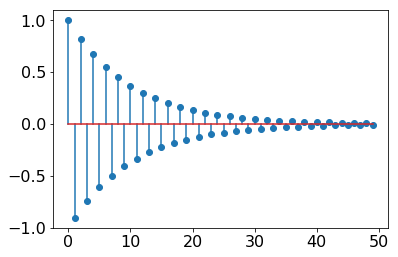

In [10]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [11]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

1.2204013486172463e-06

In [12]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.4226098381952788e-07

### Choice of the model

In [13]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [14]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06327305240665275


### Get a very precise minimum to compute distances to minimum

In [15]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5229603099732965
2.3368591785623728e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [16]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [17]:
# Number of iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [18]:
@njit
def gd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x -= step * grad(x, *args)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [19]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [20]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new = y - step * grad(y, *args)
        t_new = 1/2 * (1 + np.sqrt(1 + 4 * t ** 2))
        y_new = x_new + (t - 1) / t_new * (x_new - x)
        
        x = x_new 
        t = t_new
        y = y_new
        ### END TODO
    return x, x_list

In [21]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s nonlinear conjuguate gradient solver. First, define a function to run scipy algorithms and return the list of iterates.

In [22]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [23]:
# Nonlinear Conjugate gradient algorithm
from scipy.optimize import fmin_cg

x_init = np.zeros(d)

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

         Current function value: 0.522984
         Iterations: 50
         Function evaluations: 81
         Gradient evaluations: 81


### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [24]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [25]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    plt.figure(figsize=(15, 5))
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

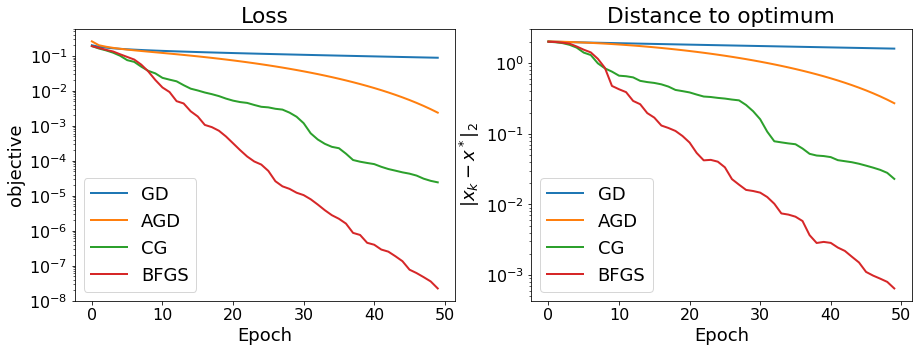

In [26]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]

solvers = ["GD", "AGD", "CG", "BFGS"]

plot_epochs(monitors, solvers)

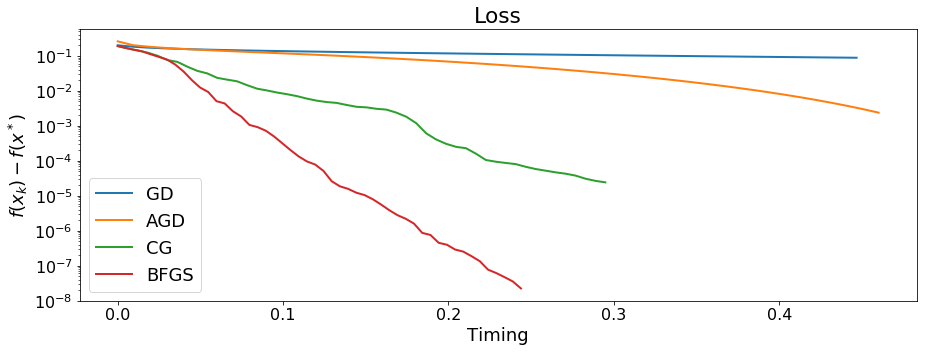

In [27]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

- We observe that scipy solvers are far more efficient than GD and AGD algorithms. Indeed the loss and distance to the minimum decreases faster (less time and less iterations) for L-BFGS and Conjugate Gradient.
- AGD converges faster than GD as it is an accelerated algorithm and as the convergence rate are respectively $O(\frac{1}{T^2})$ and $O(\frac{1}{T})$
- By increasing the number of iterations, we observe that the AGD loss and distance to the minimum increase sometimes. Indeed, AGD is not a gradient descent method.

<a id='stoc'></a> 
## 4. Stochastic methods

In [28]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [29]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x -= step / np.sqrt(idx + 1) * grad_i(i, x, *args)
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [30]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [31]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []

    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        averaged_gradient -= gradient_memory[i, :] / n
        gradient_memory[i, :] = grad_i(i, x, *args)
        averaged_gradient += gradient_memory[i, :] / n

        x -= step * averaged_gradient
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [32]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [33]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        
        ### TODO
        if idx % n == 0:
            x_old = x 
            mu = grad(x, *args)
            
        i = iis[idx]
        g = grad_i(i, x, *args) - grad_i(i, x_old, *args) + mu
        x = x - step * g
        ### END TODO        
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [34]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

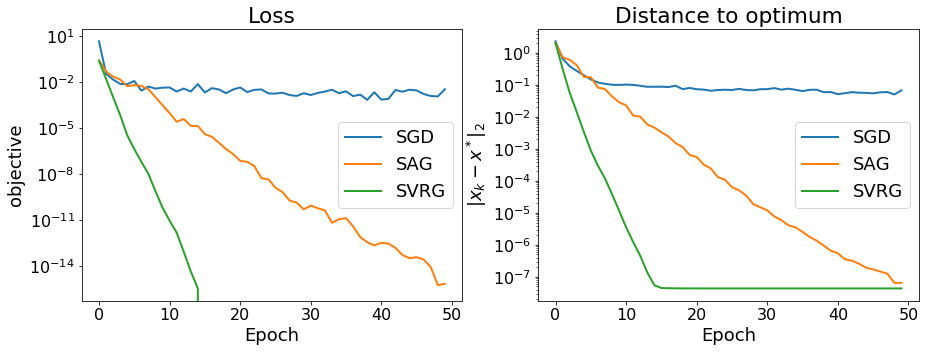

In [35]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

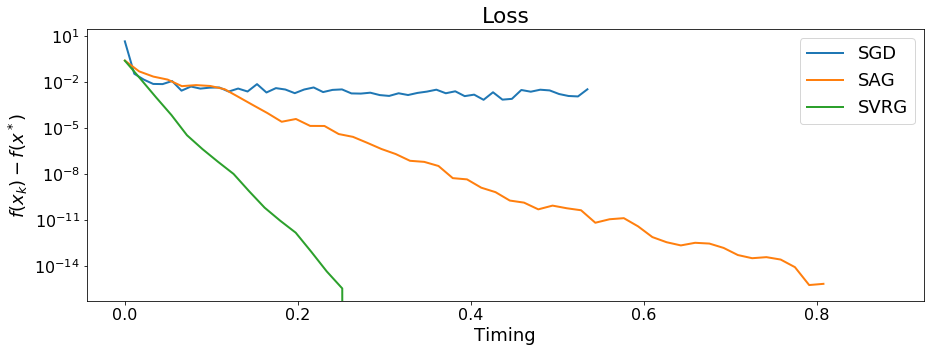

In [36]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

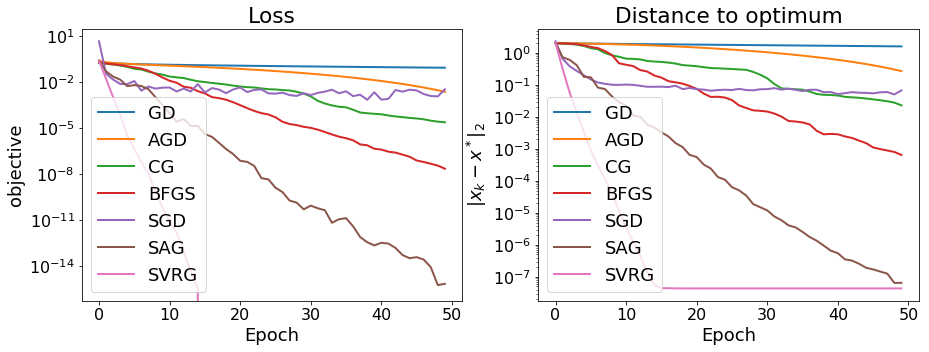

In [37]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

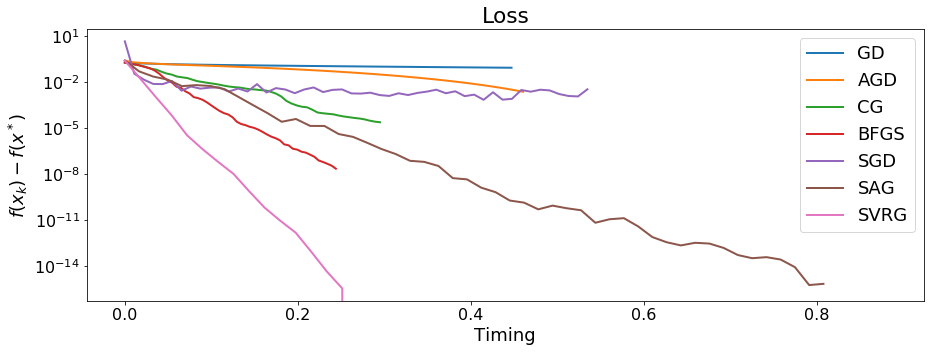

In [38]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

- SGD performs better than batch gradient descent especially for the first iterations (one of the best convergence rate) but we then can see that the objective function fluctuates heavily. It's because of the frequent updates with high variance performed by SGD. These fluctuations complicates the convergence to the exact minimum.
- After 50 iterations, SAG almost reach the optimum reached by SVRG (the best observation here), but it takes four times more time to compute the objective value reached by SVRG in about 12 iterations. This is probably because of the "gradient_memory" variable (a 10000 x 50 numpy array) which allows us to store in memory all computed gradients but makes every iteration slower on the other hand. We observe the same fluctuations as in SGD which means high variance updates but SAG converges faster because of the use of the average of gradients.
- We observe that SVRG is far more efficient than scipy BFGS algorithm which was the best algorithm among the deterministic solvers studied in part 3. SVRG is also the best solver among the stochastic methods studied in part 4. From the first iterations, it converges faster to the optimum and so the loss decreases constantly. We can see that the convergence is stable (reduced variance) in comparison with SGD and SAG because, every iteration, SVRG adjusts a stochastic gradient by the latest full gradient (which is only periodically computed). We also do not need to store all the gradients like SAG.
- GD, SGD and AGD are the algorithms with the slowest convergence rate here even if AGD seems to be more efficient than SGD on the long term.
- Scipy optimizers (CG and BFGS), even though they do not reach the optimum, run their 50 iterations really fast.

In [39]:
# run all the methods

def run_all(method_list, A, b ,lbda):
    
    sol_ini_alg = method_list
    nr_solvers = len(sol_ini_alg)
    monitors_all = []
    for si in np.arange(nr_solvers): 
        x_init = np.zeros(d)
        monitor_si = monitor(sol_ini_alg[si], loss, x_min, (A, b ,lbda))

        if si < 2:  # i.e. si == 0: GD, and si == 1: AGD        
            step = 1. / lipschitz_linreg(A, b, lbda)      
            monitor_si.run(x_init, grad,  n_iter, step, args=(A, b, lbda))
        elif si == 2: # si == 2: CG   
            monitor_si.run(loss, x_init, grad,  maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)
        elif si == 3:  # si == 3: BFGS
            monitor_si.run(loss, x_init, grad,  maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)
        elif si >= 4 and si < 6:   
            if si == 4: # si == 4: SGD
                step0 = 1e-1        
            elif si == 5: # si == 5: SAG 
                step0 = 1.0 / (max_squared_sum + lbda)      
            monitor_si.run(x_init, iis, grad_i, n_iter*n,step0, args=(A, b, lbda))            
        elif si == 6: # SVRG
            step = 1.0 / (max_squared_sum + lbda) 
            monitor_si.run(x_init, iis, grad, grad_i, n_iter*n,step, args=(A, b, lbda))

        monitors_all.append(monitor_si)
    
    return monitors_all

<b>Change the value of the ridge regularization (the lbda parameter) to low ridge  λ=1/nλ=1/n  and high ridge regularization  λ=1/n⎯⎯√λ=1/n  and compare your results. Comment.</b>

In [40]:
# run all the model with lower ridges
lbda_low = 1. / n
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda_low), pgtol=1e-30, factr=1e-30)
max_squared_sum = np.max(np.sum(A ** 2, axis=1))

sol_ini_alg = [gd, agd, scipy_runner(fmin_cg), scipy_runner(fmin_l_bfgs_b), sgd, sag, svrg]
monitors_lower = run_all(sol_ini_alg, A, b, lbda_low)

         Current function value: 0.499137
         Iterations: 50
         Function evaluations: 84
         Gradient evaluations: 84


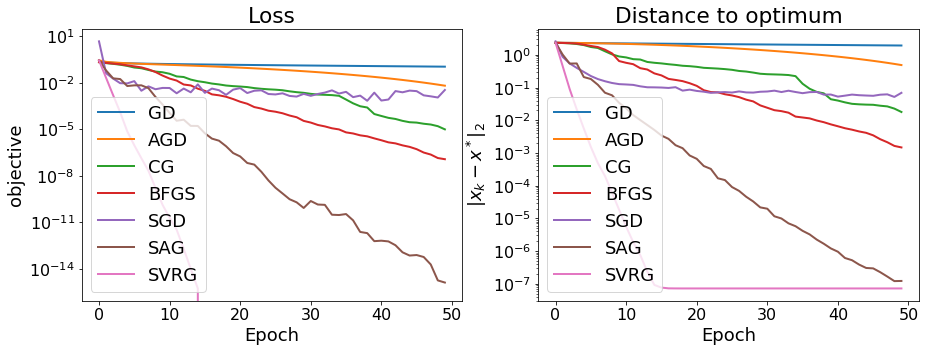

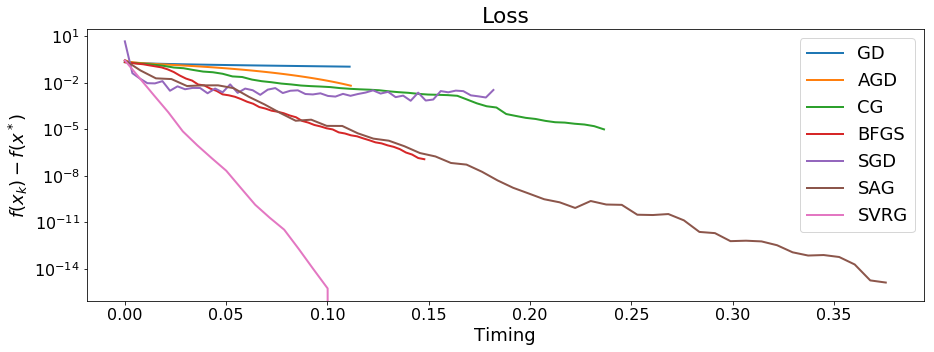

In [41]:
solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]
plot_epochs(monitors_lower, solvers)
plot_time(monitors_lower, solvers)

In [42]:
monitor_obj_high_ridge = [monitor_gd.obj[-1], monitor_agd.obj[-1], monitor_cg.obj[-1], 
         monitor_bfgs.obj[-1], monitor_sgd.obj[-1], monitor_sag.obj[-1], 
         monitor_svrg.obj[-1]]

monitor_obj_low_ridge = []
for moni in monitors_lower:
    monitor_obj_low_ridge.append(moni.obj[-1])

In [43]:
import pandas as pd

pd.DataFrame({'Distance to objective - low ridge' : monitor_obj_low_ridge, 
              'Distance to objective - high ridge' : monitor_obj_high_ridge},
            solvers)

,Distance to objective - high ridge,Distance to objective - low ridge
GD,8.859896e-02,1.102495e-01
AGD,2.381671e-03,6.534741e-03
CG,2.417612e-05,1.000606e-05
BFGS,2.231591e-08,1.189776e-07
SGD,3.462637e-03,3.464661e-03
SAG,6.661338e-16,1.332268e-15
SVRG,-2.220446e-16,-3.885781e-16


As we could see from above graph, the lambda level (if chosen between $1/n$ and $1/\sqrt n$) almost have no influence on the stochastic methods, it does have obvious but slight effect on the determistic method, with higher lada leading to relatively smaller step size (but not too small), and faster convergence. 

The reason for such different comes from how the steps are calculated. 

For stochastic methods: 
- SGD: the step size is constant, in our case 1e-1, therefore lbda does not play a role here
- SAG: the step size is 1/ (max_squared_sum + lbda), where max_squared_sum = np.max(np.sum(A ** 2, axis=1)), i.e. Maximum Absolute Column Sum Norm of matrix A, which is independent of lambda, and it is far larger than our chosen lambda level (smaller than one), therefore the chosen of any $ \lambda < 1$ does not affeact SAG method too much
- SVRG: the same as SAG

For deterministic method: 
- GD: step = 1. / lipschitz_linreg(A, b, lbda), i.e.step = 1/(norm(A, ord=2) * 2 / n + lbda), in our case norm(A, ord=2) * 2 / n is around 16, and if we increase lbda, the step size is slightly reduced. Therefore we could find more accurate result in each step, leading to faster convergence rate   
- AGD: the same as GD
- CD: not clear how the step is calculated, as it is from scipy library. But we suppose the step size is calcualted similarily to GD method since CD is also determinstic. 
- BFGS: the same as CD

Conclusion: When choosing lbda from $[1/\sqrt n, 1/n]$, lbda does not really play a significant role here as the step size is not influenced by lada very much. However due to the properties of matrix $A$, lada have obvious but slight effect on deterministic method, and also no effect on stochastic method.

<b>Play also with the level of correlation between features (parameter corr above), and compare results with low and high correlation.</b>

In [44]:
correlations = [0.95, 0.5, 0.2]
nr_corr = len(correlations)
lbda = 1. / n ** (0.5) 
x_init = np.zeros(d)
sol_ini_alg = [gd, agd, scipy_runner(fmin_cg), scipy_runner(fmin_l_bfgs_b), sgd, sag, svrg]
monitors_all_corr = []

for ci in np.arange(nr_corr): 
    corri = correlations[ci]
    A, b = simu_linreg(x_model_truth, n, std=1., corr=corri)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)
    max_squared_sum = np.max(np.sum(A ** 2, axis=1))
    
    monitors_corri = run_all(sol_ini_alg, A, b, lbda)
    monitors_all_corr.append(monitors_corri)

         Current function value: 0.518235
         Iterations: 50
         Function evaluations: 86
         Gradient evaluations: 86
         Current function value: 0.527616
         Iterations: 35
         Function evaluations: 59
         Gradient evaluations: 58
         Current function value: 0.528879
         Iterations: 20
         Function evaluations: 108
         Gradient evaluations: 96


we plot the case for correlation = 0.95


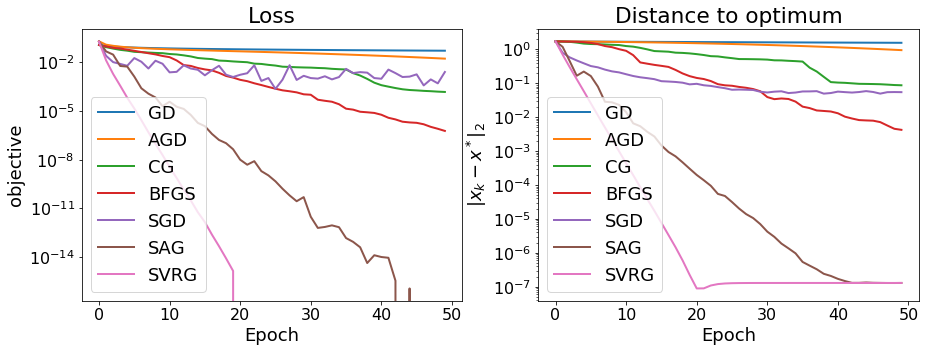

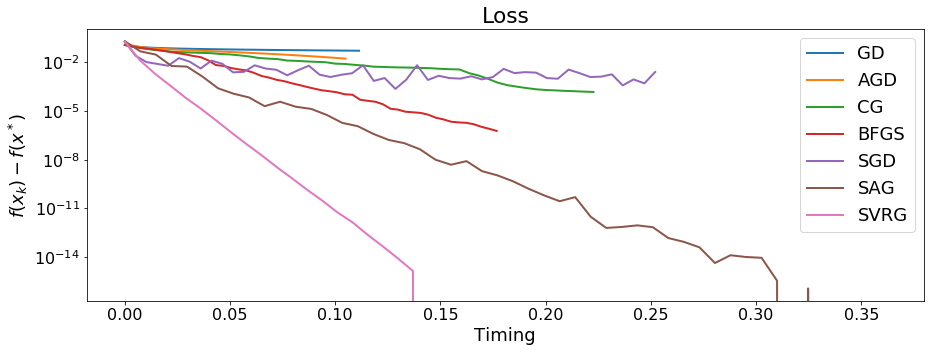

In [45]:
print ("we plot the case for correlation = " + str(correlations[0]))
plot_epochs(monitors_all_corr[0], solvers)
plot_time(monitors_all_corr[0], solvers)

we plot the case for correlation = 0.5


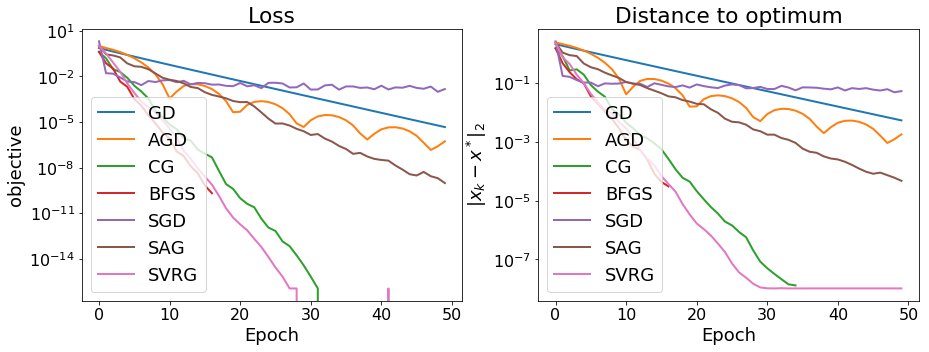

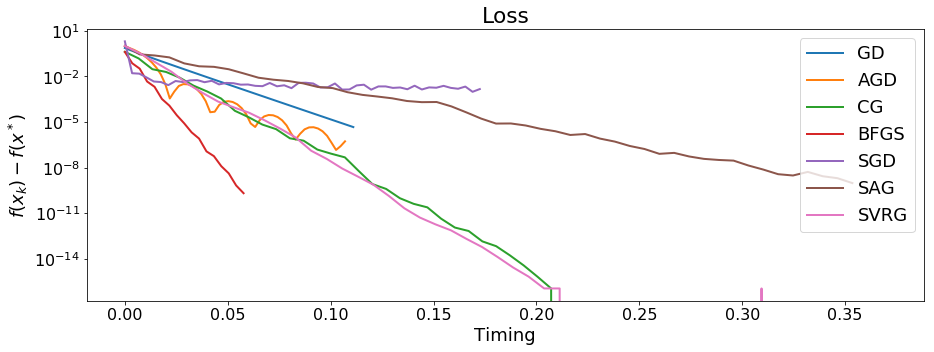

In [46]:
print ("we plot the case for correlation = " + str(correlations[1]))
plot_epochs(monitors_all_corr[1], solvers)
plot_time(monitors_all_corr[1], solvers)

we plot the case for correlation = 0.2


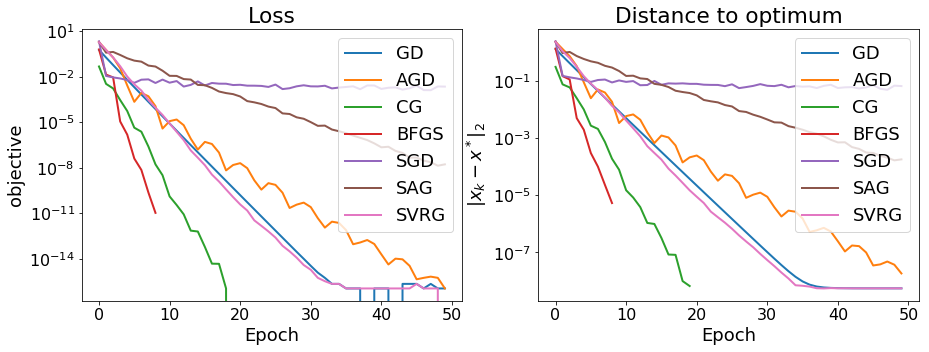

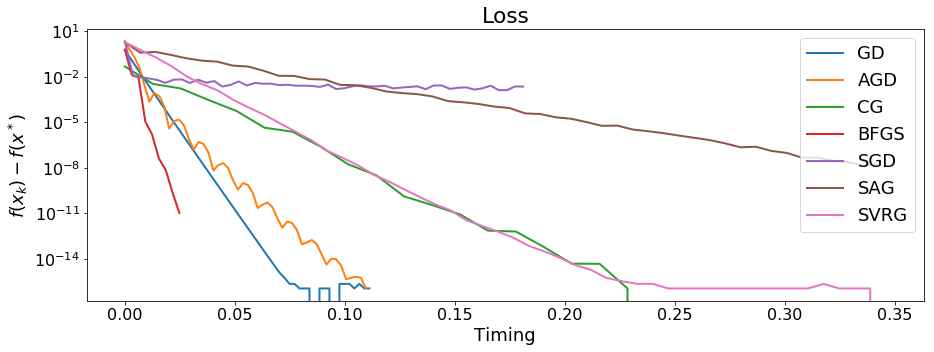

In [47]:
print ("we plot the case for correlation = " + str(correlations[2]))
plot_epochs(monitors_all_corr[2], solvers)
plot_time(monitors_all_corr[2], solvers)

- We observe that deterministic methods converge faster when features are weakly correlated. It has the opposite effect for stochastic methods SAG and SVRG.
- For deterministic methods, higher correlation means higher condition number of the matrix and therefore it takes much more time to converge compared to a matrix with lower conditional number.
- The less correlation there is between features, the less we observe fluctuations on SGD and SAG as the frequent updates are no longer characterized by their high variance. SAG starts behaving like SVRG in terms of fluctuations meaning less variance on each update leading to a stable convergence. SAG is still far slower than SVRG as explained above.
- Finally, we observe that BFGS and CG perform the best with low correlation.

<b>Conclusion</b>

In this lab, we have been studying 4 deterministic algorithms and 3 stochastic algorithms. We have adjusted the regularization level and the correlation between features. We have seen that :
- Deterministic methods (GD, AGD, CG and BFGS) perform well when the features are weakly correlated. Otherwise, they converge very slowly except for scipy BFGS.
- Stochastic methods SVRG and SAG perform well when the features are highly corrected. When increasing the correlation, SAG has a slower convergence rate. SVRG efficiency is slightly reduced and is not as good as CG but is really close to GD.
- SGD is fast in the early iterations but fails to converge to the minimum in all cases.
- Correlation has a really strong impact on the variance of the updates of SAG and SGD. With a low correlation, we observe far less fluctuations in both SGD and SAG objective function.
- The regularizer level impact slightly the performance of deterministic algorithms.

To conclude, stochastic methods are really efficient in the case of linear regression. They give good results with highly correlated data. CG and BFGS are deterministic methods that works better than GD and AGD.